# Steps to download data

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.9-cp36-none-any.whl size=73265 sha256=2a3a862a708b5fcda6e503ee615365e218393d37342ae967a612484b190eaaa2
  Stored in directory: /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [3]:
!kaggle competitions download -c dog-breed-identification

 97% 673M/691M [00:10<00:00, 86.4MB/s]
100% 691M/691M [00:10<00:00, 68.0MB/s]


In [4]:
!unzip "/content/dog-breed-identification.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: /content/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: /content/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: /content/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: /content/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: /content/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: /content/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: /content/train/83fad0718581a696132c96c166472627.jpg  
  inflating: /content/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: /content/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: /content/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: /content/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: /content/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: /content/train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating

# Multi-class Dog Breed Classification

This notebook builds an end to end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog using a dog's image

## 2. Data

The data is from Kaggle's Dog Breed Identification Competition: https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

* Images (Unstructured Data)
* 120 Breeds of Dogs (120 Classes)
* 10,000+ images in the training set (with labels)
* 10,000+ images in the testing set (without labels)

# Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import tensorflow_hub as hub
import os

from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

from IPython.display import Image

In [19]:
# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


# Constants

In [87]:
LABELS_FILE = '/content/labels.csv'
TRAIN_FILE = '/content/train/'
TEST_FILE = '/content/test/'

SAMPLE_IMAGES_FOLDER = '/content/sample_images/'
LOGS_FOLDER = '/content/logs'
MODELS_FOLDER = '/content/models'

BATCH_SIZE = 32
IMG_SIZE = 224

NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max: 10000, step: 1000}

# Input Shape, Output Shape, Model URL
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels
OUTPUT_SHAPE = 120 # len(unique_breeds)
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

# EPOCH 
NUM_EPOCHS = 100 #@param {type: "slider", min:10, max:100, step: 10}

# Load Data

In [21]:
labels_csv = pd.read_csv(LABELS_FILE)

print(labels_csv.head())
print(labels_csv.shape)

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
(10222, 2)


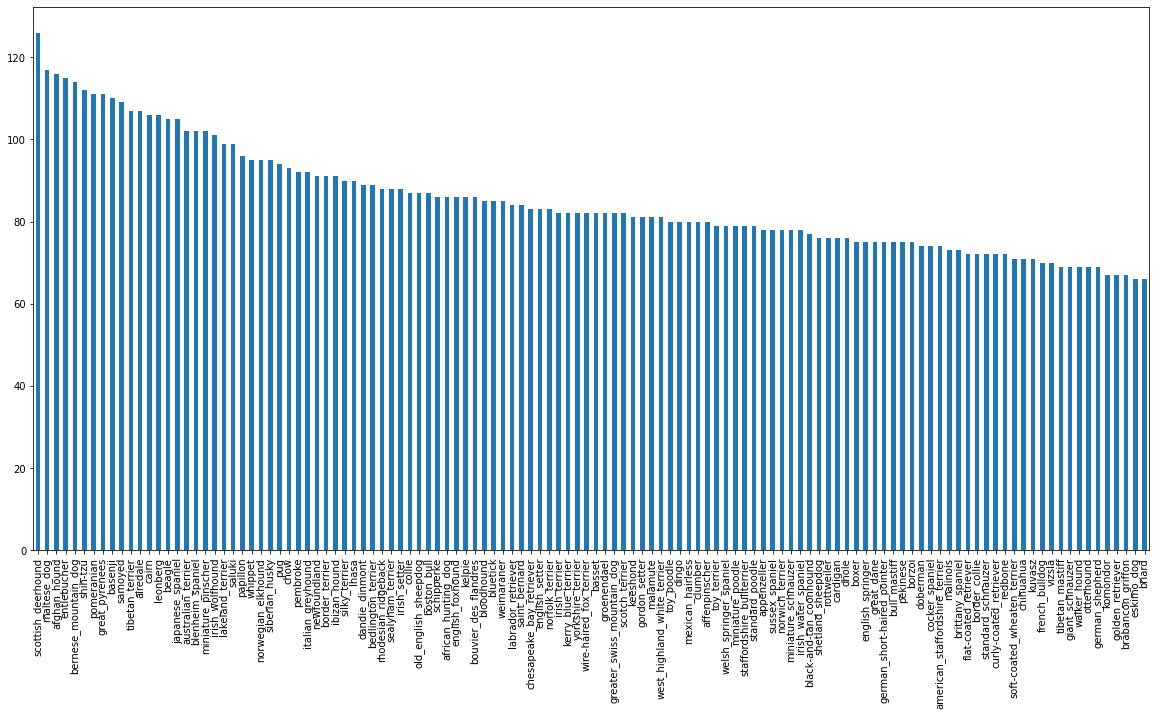

In [22]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

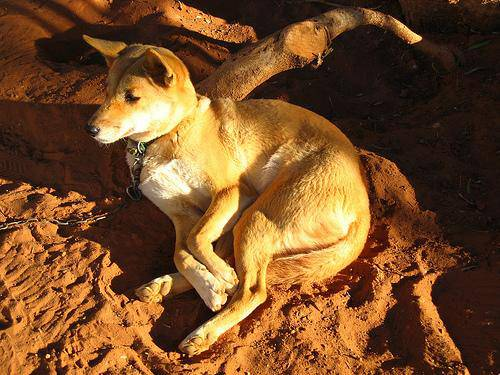

In [23]:
# Viewing an image
Image(TRAIN_FILE + '001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels


In [24]:
filepaths = [TRAIN_FILE + fname + '.jpg' for fname in labels_csv["id"]]
filepaths[:10]

['/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [25]:
if len(os.listdir(TRAIN_FILE)) == len(filepaths):
  print("Filenames matched")
else:
  print("Filenames do not match")

Filenames matched


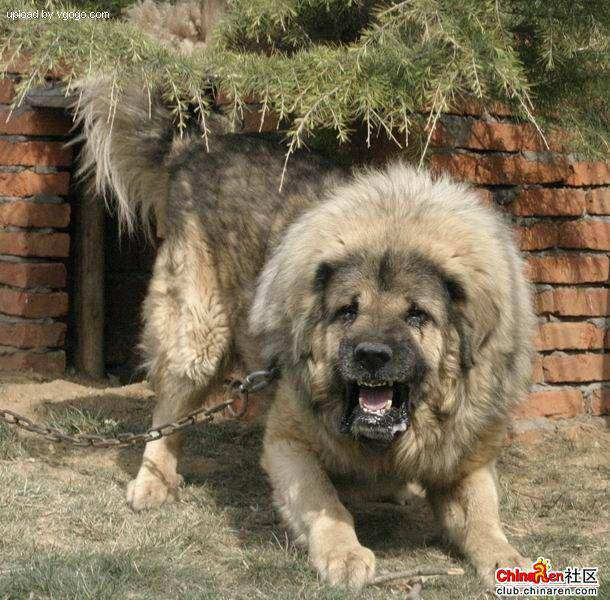

In [26]:
# Testing
Image(filepaths[9000])

In [27]:
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [28]:
# Find unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [29]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [30]:
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # array of zeroes that contains 1 on the index value

19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating the validation set


In [31]:
X = filepaths
y = boolean_labels

In [32]:
# Splitting the data

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

In [33]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

# Preprocessing the Images

Function:
* Take an image filepath
* Use tensorflow to read the file and save it to a variable, `image`
* Turn our `image` (jpg) into Tensor
* Resize the `image` to (224, 224)
* Return the modified `image`

In [34]:
def process_image(image_path):
  """
  Takes an image file path and turns in image into a tensor
  """

  # Read image file
  image = tf.io.read_file(image_path)

  # JPG to tensor (with 3 color channels)
  image = tf.image.decode_jpeg(image, channels=3)

  # Normalize the color channels (0-255 to 0-1)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [35]:
def get_image_label(image_path, label):
  """
  Takes an image file path name and its label,
  processes the image and returns a tupe of (image, label)
  """

  image = process_image(image_path)
  return image, label

In [36]:
# Turn our data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs. 
  Shuffles (only) the training data.
  Accepts test data as inputs (no labels).
  """

  # Check dataset type
  if test_data:
    print("Creating test data batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE) # process the image and turn it into a batch of 32

    return data_batch

  elif valid_data:
    print("Creating validation data batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # filepaths and labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE) # create (image, label) tuples (also preprocess the image)

    return data_batch

  else:
    print("Creating training data batches..")
    
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffling filepaths and labels
    data = data.shuffle(buffer_size=len(X))

    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)

  return data_batch

In [37]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches..
Creating validation data batches..


In [38]:
# Check different attributes of data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [39]:
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """

  # Setup the figure
  plt.figure(figsize=(10,10))

  for i in range(25):
    
    # Create subplots (5 x 5)
    ax = plt.subplot(5, 5, i+1)

    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

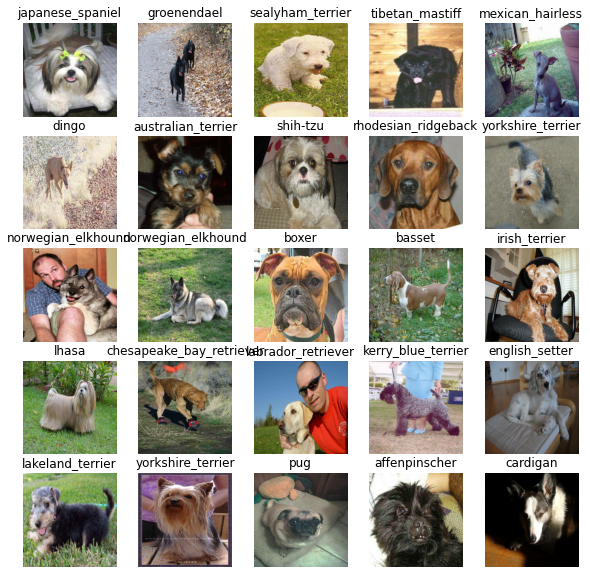

In [40]:
# Convert the batched data (train_data) into an iterator
train_images, train_labels = next(train_data.as_numpy_iterator())

show_25_images(train_images, train_labels) # Training set

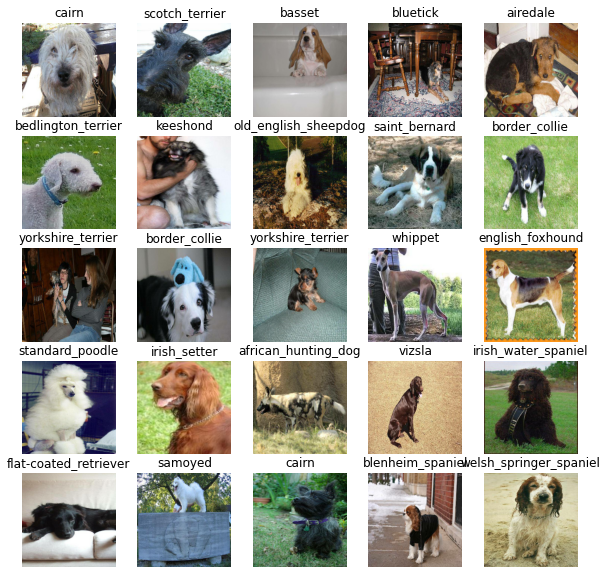

In [41]:
val_images, val_labels = next(val_data.as_numpy_iterator())

show_25_images(val_images, val_labels) # Validation set

# Building the Model

## Transfer Learning
We'll make use of a pretrained model from TensorFlow Hub

The URL of the model: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [42]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", model_url, '\n')

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url), # Input Layer
    tf.keras.layers.Dense(units=output_shape, 
                          activation="softmax") # Output layer
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  
  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [43]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating callbacks

Callbacks are helper functions that are applied at the given stages of training like -- stopping training when you reach a certain accuracy/loss score, saving your model as a checkpoint after each successful epoch, adjusting the learning rates over time, and more.

#### TensorBoard

In [44]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [45]:
def create_tensorboard_callback():
  
  # Create a log directory 
  if not os.path.exists(LOGS_FOLDER):
    os.mkdir(LOGS_FOLDER)
  
  logdir = os.path.join(LOGS_FOLDER, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(log_dir=logdir)

#### EarlyStopping

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

### Training the model

We'll start with a subset of data (1000 images) to make sure everything is working

In [47]:
# Build a function to train and return a trained model
def train_model(): 
  """
  Trains a given model and return a trained version
  """

  # Create the model
  model = create_model()

  # Create a new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model 
  model.fit(x=train_data, 
            epochs=NUM_EPOCHS, 
            validation_data=val_data, 
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model

In [ ]:
# Fit the model
model = train_model()

#### Checking the TensorBoard logs

In [ ]:
%tensorboard --logdir /content/logs

### Making and evaluating predictions


In [ ]:
predictions = model.predict(val_data, verbose=1)

In [ ]:
# First prediction
index = 0

print(f"Max value (probability): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted Label: {unique_breeds[np.argmax(predictions[index])]}")

In [49]:
# Turn prediction probabilities into corresponding labels
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [50]:
def unbatchify(data):
  """
  Takes a batched dataset of (image, labels) Tensors and returns separate arrays of images and labels.
  """

  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

val_images, val_labels = unbatchify(val_data)

In [51]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """

  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  pred_label = get_pred_label(pred_prob)

  # Green if model predicted accurately
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% {}".format(pred_label, 
                                        np.max(pred_prob)* 100, 
                                        true_label),
                                        color=color)


  # Plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

In [ ]:
plot_pred(predictions, val_labels, val_images)

In [52]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 predictions with truth label for sample n
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]
  pred_label = get_pred_label(pred_prob)

  # Top 10 indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find top 10 predictions
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color='grey')
  
  plt.xticks(np.arange(len(top_10_pred_labels)), 
             labels=top_10_pred_labels, 
             rotation="vertical")
  
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass

In [ ]:
plot_pred_conf(predictions, val_labels, n=9)

In [ ]:
# More predictions and their different values
i_multiplier = 30
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(10 * num_cols, 5 * num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i+1)
  plot_pred(predictions, val_labels, val_images, n=i+i_multiplier)

  plt.subplot(num_rows, 2 * num_cols, 2 * i+2)
  plot_pred_conf(predictions, val_labels, n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

### Saving and loading the trained model

In [60]:
def save_model(model, suffix=None):
  """
  Saves a given model in the directory and appends a suffix (string).
  """

  # Create a model directory 
  if not os.path.exists(MODELS_FOLDER):
    os.mkdir(MODELS_FOLDER)

  modeldir = os.path.join(MODELS_FOLDER, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + '-' + suffix + '.h5' # save format of model

  print(f'Saving the model to: {model_path}...')
  model.save(model_path)

  return model_path

In [61]:
def load_model(model_path):
  """
  Loads a saved model 
  """

  print(f'Loading the saved model from: {model_path}')
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  
  return model

In [ ]:
# Saving our model
new_model_path = save_model(model, suffix='1000-images-mobilenetv2')

In [ ]:
# Loading our model
loaded_1000_image_model = load_model(new_model_path)

In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

### Training the model (on Full Data)

In [53]:
len(X), len(y)

(10222, 10222)

In [54]:
# Create a data batch with the full dataset (Only training batch)
full_data = create_data_batches(X, y)

Creating training data batches..


In [55]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [56]:
# Create a model for full dataset
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4 



In [57]:
# Create a full model callbacks
full_model_tensorboard = create_tensorboard_callback()

full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note**: Running the cell below may take a little while (upto 30 minutes for the first epoch)

In [58]:
# Fit the model
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
  1/320 [..............................] - ETA: 0s - loss: 5.0876 - accuracy: 0.0625WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


  2/320 [..............................] - ETA: 38s - loss: 5.4243 - accuracy: 0.0312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0970s vs `on_train_batch_end` time: 0.1463s). Check your callbacks.


320/320 [==============================] - 41s 129ms/step - loss: 1.3390 - accuracy: 0.6694
Epoch 2/100
320/320 [==============================] - 41s 129ms/step - loss: 0.4003 - accuracy: 0.8825
Epoch 3/100
320/320 [==============================] - 35s 110ms/step - loss: 0.2401 - accuracy: 0.9339
Epoch 4/100
320/320 [==============================] - 36s 113ms/step - loss: 0.1519 - accuracy: 0.9654
Epoch 5/100
320/320 [==============================] - 41s 129ms/step - loss: 0.1049 - accuracy: 0.9794
Epoch 6/100
320/320 [==============================] - 41s 129ms/step - loss: 0.0772 - accuracy: 0.9868
Epoch 7/100
320/320 [==============================] - 41s 129ms/step - loss: 0.0582 - accuracy: 0.9914
Epoch 8/100
320/320 [==============================] - 41s 129ms/step - loss: 0.0467 - accuracy: 0.9940
Epoch 9/100
320/320 [==============================] - 41s 129ms/step - loss: 0.0363 - accuracy: 0.9969
Epoch 10/100
320/320 [==============================] - 39s 121ms/step - los

In [62]:
full_model_path = save_model(full_model, suffix="full-image-set-mobilenetv2")

Saving the model to: /content/models/20201028-150214-full-image-set-mobilenetv2.h5...


In [63]:
loaded_full_model = load_model(full_model_path)

Loading the saved model from: /content/models/20201028-150214-full-image-set-mobilenetv2.h5


### Making and evaluating predictions (Test dataset)

Before we begin,
* Get the test image filenames
* Convert the filenames into test data batches
* Make a predictions array


In [64]:
# Load test image filenames
test_filepaths = [TEST_FILE + fname for fname in os.listdir(TEST_FILE)]

test_filepaths[:10]

['/content/test/48451daf486fc0f8ccbe626de80e876f.jpg',
 '/content/test/75a6b64ece13f8c91f666fffa6a571d7.jpg',
 '/content/test/6d1f9d9b9da664c396aef5cad54a8ed8.jpg',
 '/content/test/6e76195df25fabb19e17c1f2bf8a305f.jpg',
 '/content/test/4416be97fcec5187b6b089093c8e5c37.jpg',
 '/content/test/52cab2e66727470960de51200f7c0e8f.jpg',
 '/content/test/0fa8b51dbcf4db355110909c624fb37f.jpg',
 '/content/test/efc4b489fc15ff97a50536c71029a8b1.jpg',
 '/content/test/ff194ab5709702a2eafb5e9063348776.jpg',
 '/content/test/f96722fdd8a6a0e9ff86eee619cec34d.jpg']

In [65]:
test_data = create_data_batches(test_filepaths, test_data=True)

Creating test data batches..


In [66]:
# Make predictions
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 38s 118ms/step


In [67]:
# Save predictions 
np.savetxt('/content/preds_array.csv', test_predictions, delimiter=',')

In [68]:
# Load predictions 
test_predictions = np.loadtxt('/content/preds_array.csv', delimiter=',')

In [69]:
test_predictions[:10]

array([[1.46225556e-08, 1.83575928e-08, 3.05839971e-11, ...,
        1.80707269e-10, 1.43245515e-07, 1.90743905e-12],
       [4.97913967e-11, 3.37641373e-11, 7.41079953e-09, ...,
        1.04373669e-10, 5.06262188e-09, 2.31454677e-12],
       [3.05680620e-10, 7.01421532e-10, 1.19522985e-11, ...,
        2.16065810e-09, 2.68448708e-10, 7.04919345e-10],
       ...,
       [2.13883728e-12, 7.72939435e-10, 5.34569944e-10, ...,
        1.11701847e-05, 8.19321336e-13, 1.17462581e-10],
       [1.36612177e-09, 5.63568889e-08, 9.61567857e-05, ...,
        3.73520447e-06, 4.85745844e-09, 3.59271553e-07],
       [5.46868506e-08, 7.61508854e-05, 4.34411707e-09, ...,
        3.30800876e-09, 4.01210194e-08, 1.01176905e-03]])

In [71]:
test_predictions.shape

(10357, 120)

#### Preparing the test dataset predictions for Kaggle

In [72]:
# Create a pandas DataFrame
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [76]:
# Append test Image IDs to DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(TEST_FILE)]
test_ids[:5]

['48451daf486fc0f8ccbe626de80e876f',
 '75a6b64ece13f8c91f666fffa6a571d7',
 '6d1f9d9b9da664c396aef5cad54a8ed8',
 '6e76195df25fabb19e17c1f2bf8a305f',
 '4416be97fcec5187b6b089093c8e5c37']

In [81]:
preds_df["id"] = test_ids

In [82]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,48451daf486fc0f8ccbe626de80e876f,1.46226e-08,1.83576e-08,3.0584e-11,2.48534e-10,1.99876e-07,1.15086e-11,4.15825e-10,4.24219e-10,1.11546e-09,3.81481e-09,4.4464e-07,1.04455e-07,2.43757e-10,1.47605e-08,1.45447e-07,3.16068e-11,3.75908e-06,3.16688e-11,6.74887e-07,2.62487e-09,5.9773e-09,4.93793e-11,1.75909e-10,6.01469e-09,4.727e-09,3.57058e-10,3.18668e-13,3.11275e-07,2.15212e-07,9.02645e-11,4.53012e-09,5.47514e-07,1.12583e-08,3.387e-07,5.56115e-08,1.98843e-07,1.67168e-08,1.39708e-09,9.66477e-10,...,4.83326e-11,1.22902e-07,0.998723,2.28755e-06,1.82095e-10,1.10792e-07,2.66292e-11,7.02473e-10,9.8053e-11,1.09202e-07,1.05048e-07,7.26666e-09,7.47785e-10,1.0213e-10,0.00076736,1.02988e-07,1.17307e-06,2.29481e-08,4.25762e-05,1.04543e-09,2.65954e-09,6.36798e-07,1.06475e-12,1.31441e-07,5.08997e-07,3.37753e-06,2.25019e-08,1.17516e-08,2.41545e-05,3.93685e-08,5.57642e-10,1.63478e-11,1.13285e-10,2.29598e-06,4.57428e-09,1.54839e-11,1.51121e-05,1.80707e-10,1.43246e-07,1.90744e-12
1,75a6b64ece13f8c91f666fffa6a571d7,4.97914e-11,3.37641e-11,7.4108e-09,5.35482e-12,2.89013e-11,1.70357e-09,2.19921e-13,4.66696e-09,2.28614e-11,4.14148e-08,6.60935e-10,1.93603e-10,1.19348e-09,3.527e-10,2.98911e-09,6.49056e-10,1.36382e-11,3.14022e-08,2.31293e-08,1.96922e-09,1.85735e-10,1.51976e-12,6.55252e-09,4.45901e-08,3.18174e-10,5.41921e-11,1.27195e-09,1.89963e-07,2.26791e-08,9.55942e-11,2.18934e-10,2.88813e-09,5.82545e-11,1.76546e-08,4.49809e-11,1.72773e-09,9.06023e-09,9.10385e-10,2.34884e-08,...,7.61552e-05,1.34293e-09,1.1585e-10,1.83007e-10,3.09876e-09,6.08848e-12,1.9667e-09,4.14852e-11,2.87471e-10,8.05546e-10,1.952e-09,7.1616e-09,4.3038e-09,2.54229e-09,1.82199e-08,1.97648e-08,3.3408e-10,1.47058e-09,5.25312e-11,3.5991e-08,2.09348e-10,0.000471062,3.28902e-10,6.84109e-12,2.19391e-10,1.13379e-08,3.0255e-11,4.3275e-11,6.0532e-08,1.0807e-09,1.19402e-14,5.76054e-10,4.21179e-12,1.32413e-10,1.38776e-10,4.44841e-10,2.77175e-11,1.04374e-10,5.06262e-09,2.31455e-12
2,6d1f9d9b9da664c396aef5cad54a8ed8,3.05681e-10,7.01422e-10,1.19523e-11,1.12716e-07,3.23719e-11,1.92727e-08,1.92392e-09,4.41424e-11,5.26541e-09,3.85882e-12,6.30159e-10,5.78474e-11,0.0003635,8.01001e-13,3.77885e-10,9.45986e-08,4.58658e-11,3.58666e-11,1.024e-10,1.18319e-11,8.01358e-13,1.87911e-09,7.88894e-10,9.40824e-12,9.05053e-14,7.51241e-12,6.84721e-13,1.91311e-12,1.3048e-11,1.41986e-12,9.69329e-12,3.23065e-11,2.24211e-12,1.70476e-12,1.06985e-08,3.35489e-12,7.90187e-12,3.06128e-10,0.999622,...,8.60672e-12,1.86931e-13,2.43392e-11,1.10111e-11,1.14845e-11,1.59665e-10,6.66835e-12,8.20071e-10,3.79656e-11,2.89138e-07,4.30963e-08,1.076e-05,1.08351e-12,1.94057e-11,5.17887e-11,4.51767e-10,7.86479e-12,1.55231e-09,4.4134e-10,7.92888e-11,1.62795e-12,1.9107e-11,1.52126e-08,2.43291e-10,1.80856e-08,1.31664e-11,5.58813e-09,3.70773e-10,1.82199e-11,2.86847e-11,2.72642e-11,4.16285e-08,3.3145e-08,1.16333e-09,6.97485e-09,2.54742e-11,3.97491e-10,2.16066

In [83]:
# Export the DataFrame to csv
preds_df.to_csv('/content/full_model_predictions_1.csv', index=False)

# Making predictions on Custom Images

* Find some images online and upload here
* Get filepaths of our own images
* Turn the filepaths to data batches
* Pass the image data batch to `predict()`

In [104]:
sample_image_paths = [SAMPLE_IMAGES_FOLDER + fname for fname in os.listdir(SAMPLE_IMAGES_FOLDER)]
sample_image_paths

['/content/sample_images/image-2(bernese-mountain-dog).jpg',
 '/content/sample_images/image-5(dandie dinmont).jpeg',
 '/content/sample_images/image-3(Clumber).jpg',
 '/content/sample_images/image-1(affenpinscher).jpeg']

In [105]:
# Turn custom images into batch datasets
custom_data = create_data_batches(sample_image_paths, test_data=True)

Creating test data batches..


In [106]:
# Make predictions
custom_preds = loaded_full_model.predict(custom_data)

In [107]:
custom_preds.shape

(4, 120)

In [110]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['bernese_mountain_dog', 'dandie_dinmont', 'clumber', 'affenpinscher']

In [113]:
custom_images = []

# Unbatch the dataset
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

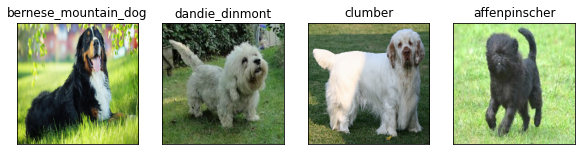

In [114]:
# Check custom image predictions
plt.figure(figsize=(10, 10))

for i, image in enumerate(custom_images):
  plt.subplot(1, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)
